# Predicting rating of a movie for a user

The dataset used is Movielens available on Kaggle: https://www.kaggle.com/grouplens/movielens-20m-dataset

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input,Embedding, dot
from keras.layers.core import Flatten, Dense
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
import numpy as np

In [2]:
ratings_df = pd.read_csv("dataset/ratings.csv")
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


In [3]:
movies_df = pd.read_csv("dataset/movies.csv")
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
# Merging the two csv files into one dataset. The join column is "movieId"
merge_df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
merge_df.shape

(20000263, 6)

In [5]:
# The dataset is quite big (20M records). Will sample 10% as the objective is to understand how Embeddings work
df = merge_df.sample(frac=0.1, random_state=1) # Shuffle
print(df.shape)
df.head(10)

(2000026, 6)


,userId,movieId,rating,timestamp,title,genres
6044706,123425,362,3.0,840651205,"Jungle Book, The (1994)",Adventure|Children|Romance
10220381,108287,1962,4.0,943528915,Driving Miss Daisy (1989),Drama
3976108,109381,1653,1.0,986857790,Gattaca (1997),Drama|Sci-Fi|Thriller
5171603,64404,17,5.0,1149564752,Sense and Sensibility (1995),Drama|Romance
5934930,137309,16,3.5,1109103381,Casino (1995),Crime|Drama
4850850,128846,356,4.0,1342557188,Forrest Gump (1994),Comedy|Drama|Romance|War
4121040,98269,2009,3.0,945893490,Soylent Green (1973),Drama|Mystery|Sci-Fi|Thriller
7831273,12679,550,4.0,967135158,Threesome (1994),Comedy|Romance
8472440,36494,2232,2.0,1210589547,Cube (1997),Horror|Mystery|Sci-Fi|Thriller
13710576,17354,79091,4.0,1401473674,Despicable Me (2010),Animation|Children|Comedy|Crime


In [6]:
print('Number of unique movieId in the dataset {}'.format(len(df.movieId.unique())))
print('Number of unique movieId in the dataset {}'.format(len(df.userId.unique())))

Number of unique movieId in the dataset 17734
Number of unique movieId in the dataset 135625


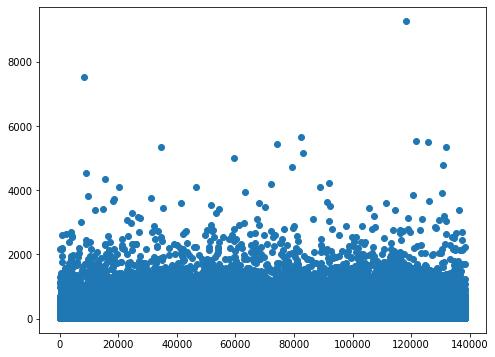

In [7]:
# Plotting the number of ratings by each user
fig, ax = plt.subplots(figsize=(8,6))
g = ratings_df.groupby('userId')['rating'].count()
plt.scatter(g.index, g)
plt.show()

Since we sampleed from the original data, we need to reset the ids.

In [25]:
unq_users =  df.userId.unique()
unq_movies = df.movieId.unique()
userid_idx = {v:idx for idx,v in enumerate(unq_users)}
movieid_idx = {v:idx for idx,v in enumerate(unq_movies)}
print(unq_users[0:5])
print(list(userid_idx.items())[0: 5])

[123425 108287 109381  64404 137309]
[(123425, 0), (108287, 1), (109381, 2), (64404, 3), (137309, 4)]


In [26]:
# Updating the original dataset
df.movieId = df.movieId.apply(lambda x: movieid_idx[x])
df.userId = df.userId.apply(lambda x: userid_idx[x])

In [20]:
# Our input consists of a combination of a userId and a movieId (input length is 1)
# userId input:
user_id_input = Input(shape=(1,), dtype='int64', name='user_id')
# movieId input: 
movie_id_input = Input(shape=(1,), dtype='int64', name='movie_id')
# Building the embedding layers 
user_embedding_size = 8
movie_embedding_size = 8
user_embedding = Embedding(len(unq_users), user_embedding_size, input_length=1, embeddings_regularizer=l2(1e-4))(user_id_input)
movie_embedding = Embedding(len(unq_movies), movie_embedding_size, input_length=1, embeddings_regularizer=l2(1e-4))(movie_id_input)

In [23]:
# We need to define how to combine these two embedding layers. In this example, we are using the dot function
dot_out = dot([user_embedding, movie_embedding], axes=-1, normalize=False)
out = Flatten()(dot_out)
model = Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(Adam(0.001), loss='mse')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 8)         1085000     user_id[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 8)         141872      movie_id[0][0]                   
__________________________________________________________________________________________________
dot_1 (Do

In [27]:
model.fit(
    [df.userId, df.movieId],
    df.rating, 
    batch_size=64, 
    epochs=1, 
    validation_split=.05,
)

Train on 1900024 samples, validate on 100002 samples
Epoch 1/1
1900024/1900024 [==============================] - 764s 402us/step - loss: 11.4468 - val_loss: 10.4397


In [28]:
# Let us try out the new trained model

In [32]:
model.predict([np.array([3]), np.array([6])])

array([[1.2771978]], dtype=float32)

In [33]:
model.save('model')